>>> LOADING DATA...
Data Loaded. Active Sales Rows: 844338

--- Evaluating: 1. Raw Data (Naive) ---
Preprocessing...
Training XGBoost (Log Target: False)...
Done. RMSPE: 0.16692

--- Evaluating: 2. Business Logic Features ---
Preprocessing...
Training XGBoost (Log Target: True)...
Optimizing correction factor...
Best Factor: 0.98
Done. RMSPE: 0.14222

--- Evaluating: 3. Entity Embeddings ---
Preprocessing...

[EntityEmbedding] 1. Feature Engineering (Train)...
[EntityEmbedding] 2. Computing Medians...
[EntityEmbedding] 3. Fitting Label Encoders...
[EntityEmbedding] 4. Scaling Continuous Variables...

[Embed Training] Device: cuda | Batch Size: 256
[Embed Training] Start training for 20 epochs...
  >> Epoch 1/20 | Loss (MSE): 2.39069
  >> Epoch 2/20 | Loss (MSE): 0.12203
  >> Epoch 3/20 | Loss (MSE): 0.06813
  >> Epoch 4/20 | Loss (MSE): 0.05530
  >> Epoch 5/20 | Loss (MSE): 0.05009
  >> Epoch 6/20 | Loss (MSE): 0.04697
  >> Epoch 7/20 | Loss (MSE): 0.04392
  >> Epoch 8/20 | Loss (MSE):

d:\dataviz_proj\processors.py:311: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.model_save_path, map_location=self.device))
d:\dataviz

Training XGBoost (Log Target: True)...
Optimizing correction factor...
Best Factor: 0.988
Done. RMSPE: 0.11712

FINAL LEADERBOARD (RMSPE - Lower is Better)
                               RMSPE Features Log Target
3. Entity Embeddings        0.117119       96       True
2. Business Logic Features  0.142221       22       True
1. Raw Data (Naive)         0.166923       17      False


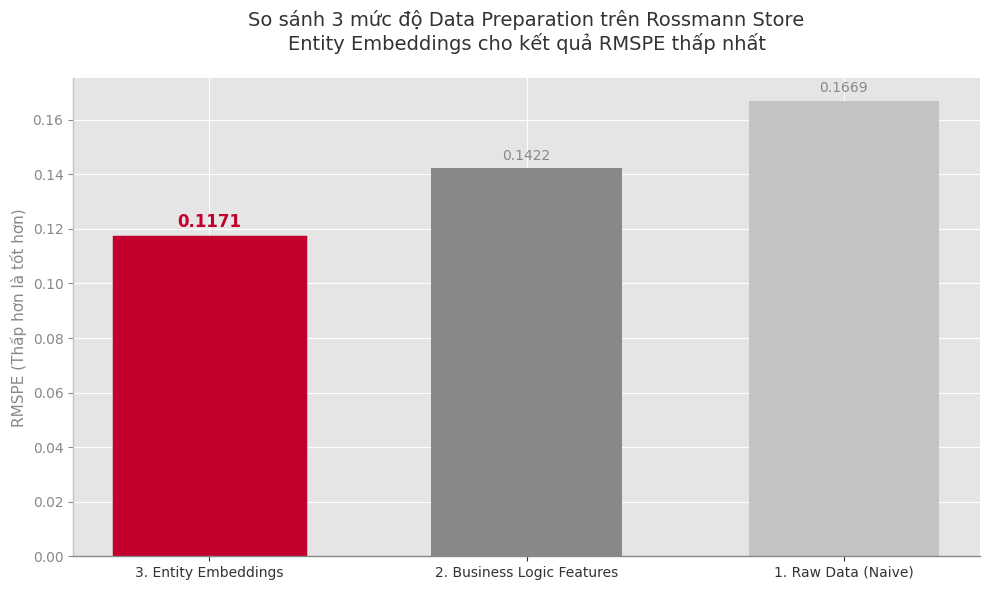

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from evaluator import RossmannComparer
from processors import RawFeatureGenerator, OptimizedFeatureGenerator, EntityEmbeddingFeatureGenerator

ROSSMANN_RED = '#C3002D'
GRAY_NEUTRAL = '#888888'
GRAY_LIGHT   = '#C3C3C3'

%matplotlib inline
plt.style.use('ggplot')

# ==========================================
# 1. LOAD DATA & FIXED PARAMS
# ==========================================
print(">>> LOADING DATA...")
train_df_full = pd.read_csv('data/train.csv', parse_dates=['Date'], low_memory=False)
store_df = pd.read_csv('data/store.csv')

train_df_full = train_df_full[(train_df_full['Open'] == 1) & (train_df_full['Sales'] > 0)]
print(f"Data Loaded. Active Sales Rows: {len(train_df_full)}")

FIXED_PARAMS = {
    'objective': 'reg:squarederror',
    'n_estimators': 300,
    'max_depth': 10,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'n_jobs': -1,
    'random_state': 42
}

comparer = RossmannComparer(
    model_params=FIXED_PARAMS,
    train_df=train_df_full,
    store_df=store_df
)

# ==========================================
# 2. CHẠY THỰC NGHIỆM (3 LEVEL)
# ==========================================

# LEVEL 1: RAW DATA
comparer.evaluate(
    pipeline_name="1. Raw Data (Naive)",
    preprocessor=RawFeatureGenerator(),
    use_log_target=False
)

# LEVEL 2: BUSINESS LOGIC FEATURES
comparer.evaluate(
    pipeline_name="2. Business Logic Features",
    preprocessor=OptimizedFeatureGenerator(),
    use_log_target=True
)

# LEVEL 3: ENTITY EMBEDDINGS
emb_pipeline = EntityEmbeddingFeatureGenerator(
    model_save_path='checkpoints/emb_model_compare.pth',
    epochs=20,
    batch_size=256
)

comparer.evaluate(
    pipeline_name="3. Entity Embeddings",
    preprocessor=emb_pipeline,
    use_log_target=True
)

# ==========================================
# 3. TỔNG HỢP & VẼ BIỂU ĐỒ
# ==========================================

summary = comparer.get_summary()
print("\n" + "="*40)
print("FINAL LEADERBOARD (RMSPE - Lower is Better)")
print("="*40)
print(summary)

plt.figure(figsize=(10, 6))
ax = plt.gca()

bar_colors = []
for name in summary.index:
    if "Entity" in name:
        bar_colors.append(ROSSMANN_RED)
    elif "Business" in name:
        bar_colors.append(GRAY_NEUTRAL)
    else:
        bar_colors.append(GRAY_LIGHT)

bars = ax.bar(summary.index, summary['RMSPE'], color=bar_colors, width=0.6)

ax.set_title(
    "So sánh 3 mức độ Data Preparation trên Rossmann Store\n"
    "Entity Embeddings cho kết quả RMSPE thấp nhất",
    fontsize=14, color='#333333', pad=20
)
ax.set_ylabel("RMSPE (Thấp hơn là tốt hơn)", fontsize=11, color=GRAY_NEUTRAL)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(GRAY_LIGHT)
ax.spines['bottom'].set_color(GRAY_NEUTRAL)
ax.tick_params(axis='x', colors='#333333', rotation=0)
ax.tick_params(axis='y', colors=GRAY_NEUTRAL)

for bar, name, color in zip(bars, summary.index, bar_colors):
    height = bar.get_height()
    is_entity = ("Entity" in name)

    if is_entity:
        bar.set_linewidth(2.5)
        bar.set_edgecolor(ROSSMANN_RED)

    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.002,
        f'{height:.4f}',
        ha='center', va='bottom',
        fontweight='bold' if is_entity else 'normal',
        color=ROSSMANN_RED if is_entity else GRAY_NEUTRAL,
        fontsize=12 if is_entity else 10
    )


plt.tight_layout()
plt.show()
